# [**Apprentissage par variétés sur chiffres manuscrits : Locally Linear Embedding, Isomap…**](https://nbviewer.org/github/Franck-PepperLabs/pepper_data-science_practising/blob/main/Sklearn/examples/2_2_manifold/plot_lle_digits.ipynb)<br/>([*Manifold learning on handwritten digits: Locally Linear Embedding, Isomap…*](https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html))

Nous illustrons diverses techniques de plongement sur le jeu de données *chiffres*.

In [2]:
# Authors: Fabian Pedregosa <fabian.pedregosa@inria.fr>
#          Olivier Grisel <olivier.grisel@ensta.org>
#          Mathieu Blondel <mathieu@mblondel.org>
#          Gael Varoquaux
#          Guillaume Lemaitre <g.lemaitre58@gmail.com>
# License: BSD 3 clause (C) INRIA 2011

# Charger l'ensemble de données *digits*

Nous allons charger le jeu de données *digits* et n'utiliser que les six premières des dix classes disponibles.

In [3]:
from sklearn.datasets import load_digits

digits = load_digits(n_class=6)
X, y = digits.data, digits.target
n_samples, n_features = X.shape
n_neighbors = 30

Nous pouvons tracer les cent premiers chiffres de cet ensemble de données.

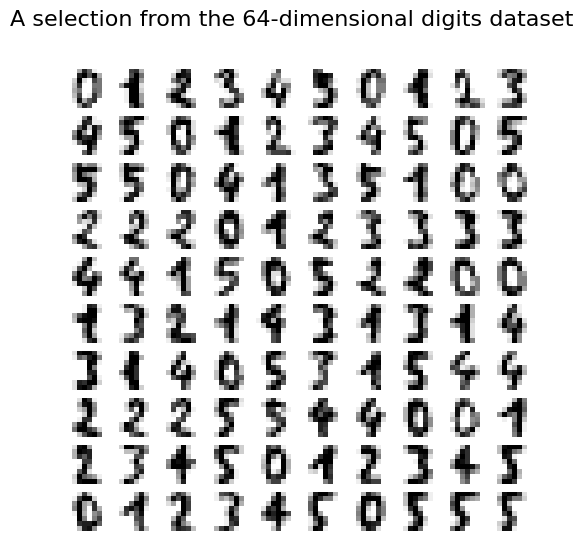

In [4]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows=10, ncols=10, figsize=(6, 6))
for idx, ax in enumerate(axs.ravel()):
    ax.imshow(X[idx].reshape((8, 8)), cmap=plt.cm.binary)
    ax.axis("off")
_ = fig.suptitle("A selection from the 64-dimensional digits dataset", fontsize=16)

# Fonction utilitaires pour tracer le plongement

Ci-dessous, nous utiliserons différentes techniques pour intégrer l'ensemble de données de chiffres. Nous allons tracer la projection des données d'origine sur chaque plongement. Cela nous permettra de vérifier si ou des chiffres sont regroupés dans l'espace d'intégration, ou dispersés à travers celui-ci.

In [1]:
import numpy as np
from matplotlib import offsetbox
from sklearn.preprocessing import MinMaxScaler


def plot_embedding(X, title):
    _, ax = plt.subplots()
    X = MinMaxScaler().fit_transform(X)

    for digit in digits.target_names:
        ax.scatter(
            *X[y == digit].T,
            marker=f"${digit}$",
            s=60,
            color=plt.cm.Dark2(digit),
            alpha=0.425,
            zorder=2,
        )
    shown_images = np.array([[1.0, 1.0]])  # just something big
    for i in range(X.shape[0]):
        # plot every digit on the embedding
        # show an annotation box for a group of digits
        dist = np.sum((X[i] - shown_images) ** 2, 1)
        if np.min(dist) < 4e-3:
            # don't show points that are too close
            continue
        shown_images = np.concatenate([shown_images, [X[i]]], axis=0)
        imagebox = offsetbox.AnnotationBbox(
            offsetbox.OffsetImage(digits.images[i], cmap=plt.cm.gray_r), X[i]
        )
        imagebox.set(zorder=1)
        ax.add_artist(imagebox)

    ax.set_title(title)
    ax.axis("off")

# Comparaison des techniques de plongement

Ci-dessous, nous comparons différentes techniques. Cependant, il y a quelques points à noter :

* le [`RandomTreesEmbedding`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomTreesEmbedding.html#sklearn.ensemble.RandomTreesEmbedding) n'est techniquement pas une méthode de plongement de variété, car il apprend une représentation de grande dimension sur laquelle nous appliquons une méthode de réduction de dimensionnalité. Cependant, il est souvent utile de convertir un ensemble de données en une représentation dans laquelle les classes sont linéairement séparables.

* la [`LinearDiscriminantAnalysis`](https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html#sklearn.discriminant_analysis.LinearDiscriminantAnalysis) et la [`NeighborhoodComponentsAnalysis`](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NeighborhoodComponentsAnalysis.html#sklearn.neighbors.NeighborhoodComponentsAnalysis), sont des méthodes de réduction de dimensionnalité supervisée, c'est-à-dire qu'elles utilisent les étiquettes fournies, contrairement à d'autres méthodes.

* le [`TSNE`](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html#sklearn.manifold.TSNE) est initialisé avec le plongement générée par PCA dans cet exemple. Il assure la stabilité globale du plongement, c'est-à-dire que le plongement ne dépend pas d'une initialisation aléatoire.

In [5]:
from sklearn.decomposition import TruncatedSVD
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomTreesEmbedding
from sklearn.manifold import (
    Isomap,
    LocallyLinearEmbedding,
    MDS,
    SpectralEmbedding,
    TSNE,
)
from sklearn.neighbors import NeighborhoodComponentsAnalysis
from sklearn.pipeline import make_pipeline
from sklearn.random_projection import SparseRandomProjection

embeddings = {
    "Random projection embedding": SparseRandomProjection(
        n_components=2, random_state=42
    ),
    "Truncated SVD embedding": TruncatedSVD(n_components=2),
    "Linear Discriminant Analysis embedding": LinearDiscriminantAnalysis(
        n_components=2
    ),
    "Isomap embedding": Isomap(n_neighbors=n_neighbors, n_components=2),
    "Standard LLE embedding": LocallyLinearEmbedding(
        n_neighbors=n_neighbors, n_components=2, method="standard"
    ),
    "Modified LLE embedding": LocallyLinearEmbedding(
        n_neighbors=n_neighbors, n_components=2, method="modified"
    ),
    "Hessian LLE embedding": LocallyLinearEmbedding(
        n_neighbors=n_neighbors, n_components=2, method="hessian"
    ),
    "LTSA LLE embedding": LocallyLinearEmbedding(
        n_neighbors=n_neighbors, n_components=2, method="ltsa"
    ),
    "MDS embedding": MDS(n_components=2, n_init=1, max_iter=120, n_jobs=2),
    "Random Trees embedding": make_pipeline(
        RandomTreesEmbedding(n_estimators=200, max_depth=5, random_state=0),
        TruncatedSVD(n_components=2),
    ),
    "Spectral embedding": SpectralEmbedding(
        n_components=2, random_state=0, eigen_solver="arpack"
    ),
    "t-SNE embedding": TSNE(
        n_components=2,
        init="pca",
        learning_rate="auto",
        n_iter=500,
        n_iter_without_progress=150,
        n_jobs=2,
        random_state=0,
    ),
    "NCA embedding": NeighborhoodComponentsAnalysis(
        n_components=2, init="pca", random_state=0
    ),
}

Une fois que nous avons déclaré toutes les méthodes d'intérêt, nous pouvons exécuter et effectuer la projection des données d'origine. Nous stockerons les données projetées ainsi que le temps de calcul nécessaire pour effectuer chaque projection.

In [6]:
from time import time

projections, timing = {}, {}
for name, transformer in embeddings.items():
    if name.startswith("Linear Discriminant Analysis"):
        data = X.copy()
        data.flat[:: X.shape[1] + 1] += 0.01  # Make X invertible
    else:
        data = X

    print(f"Computing {name}...")
    start_time = time()
    projections[name] = transformer.fit_transform(data, y)
    timing[name] = time() - start_time

Computing Random projection embedding...
Computing Truncated SVD embedding...
Computing Linear Discriminant Analysis embedding...
Computing Isomap embedding...
Computing Standard LLE embedding...
Computing Modified LLE embedding...
Computing Hessian LLE embedding...
Computing LTSA LLE embedding...
Computing MDS embedding...


C:\Users\franc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\manifold\_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


Computing Random Trees embedding...
Computing Spectral embedding...
Computing t-SNE embeedding...
Computing NCA embedding...


Enfin, nous pouvons tracer la projection résultante donnée par chaque méthode.

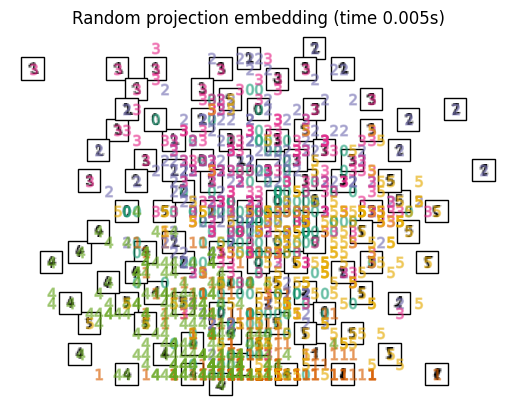

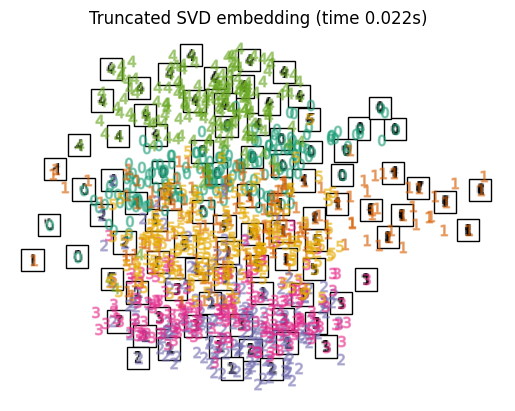

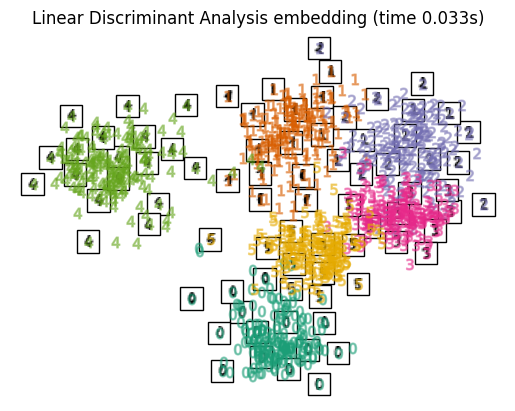

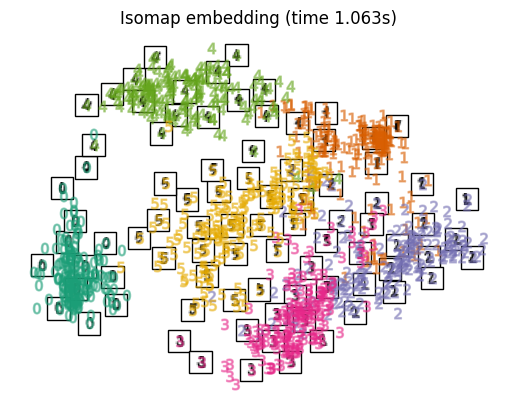

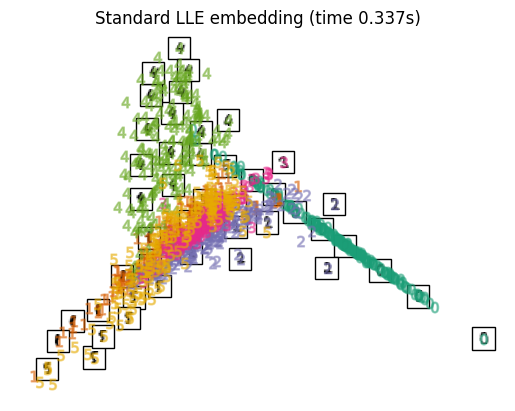

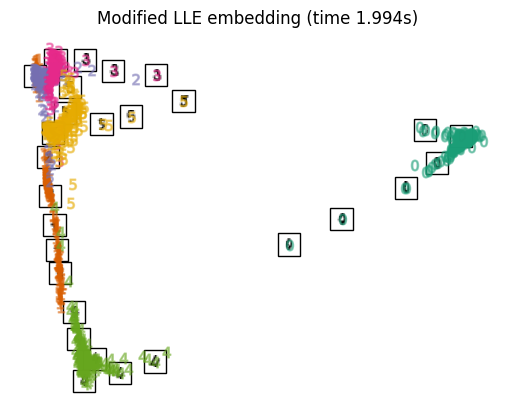

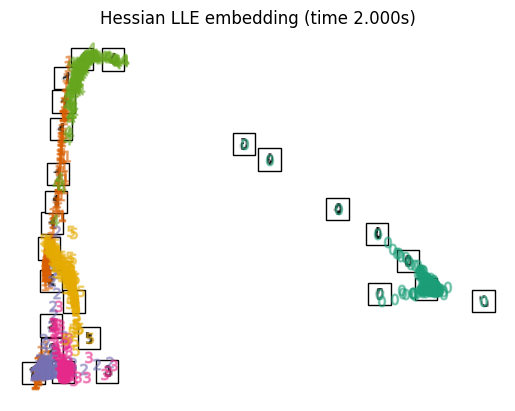

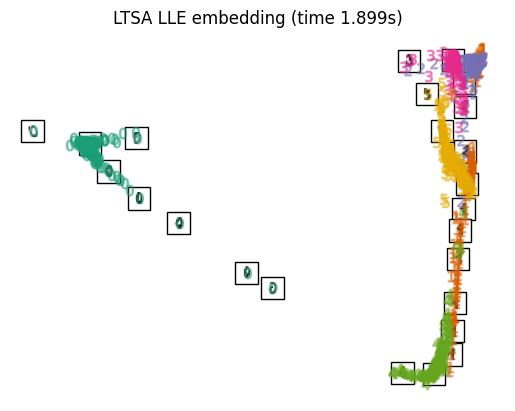

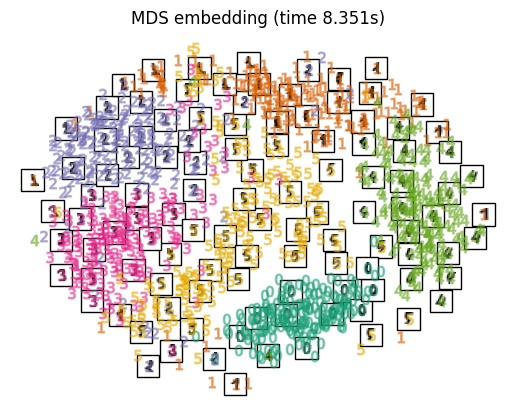

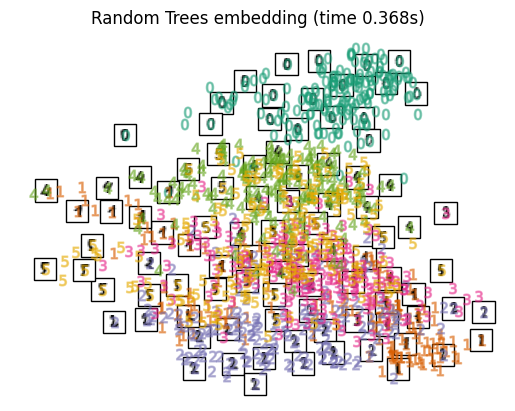

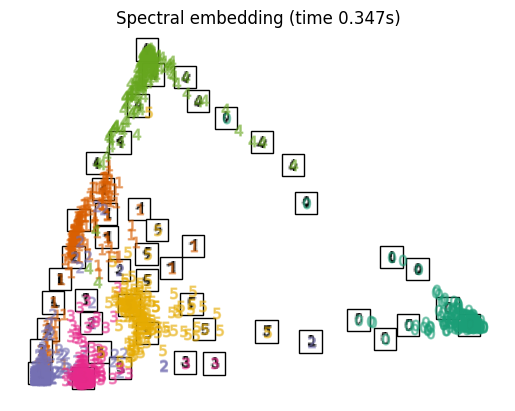

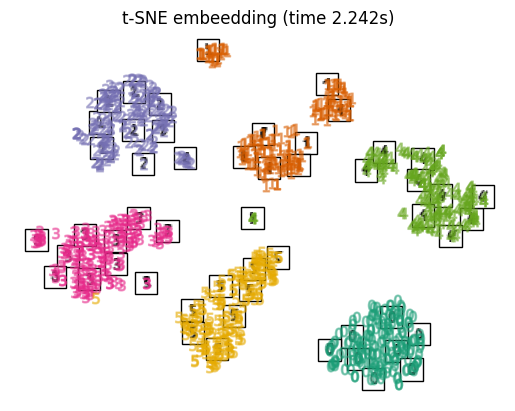

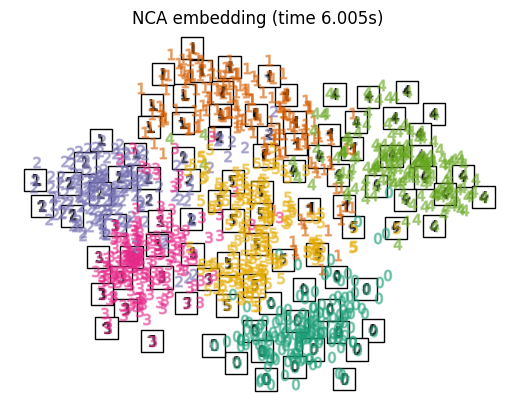

In [7]:
for name in timing:
    title = f"{name} (time {timing[name]:.3f}s)"
    plot_embedding(projections[name], title)

plt.show()